# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# House Price Forecasting with Regression Modeling

## Project Overview

The project focuses on the creation of a machine learning project for house price forecasting for all stakeholders involved from investors to owners to buyers.

## Background Information

There are comparisons that have already been done on the difference in house prices in houses having waterfronts, and those without. Research shows that the closer a house is to a waterfront, the more expensive it is. However, it is notable that the different houses with the same waterfront have different prices. There are things shared by different houses on the same front such as geographical location, available amenities and a shared waterfront or ocean. There are also differences in the houses based on the overall size of the house, the proximity to neighbors and the different provisions in the houses among others. There are situations where some houses share certain attributes such as the same number of floors, number of bathrooms and an almost similar size and design in the house, yet the houses have a different pricing, and sometimes it is difficult to understand the difference in the pricing. There are no studies and experiments, though, showing how the different factors the house prices.

## Challenges

1. External Factors: The housing market is susceptible to external factors such as changing policies and economic fluctuations, impacting price trends.

2. Insufficient Data: Limited data hampers the development of a recommendation system. We need more data on local amenities, security, and how they vary across geographical regions.


## Solutions

* Explore feature engineering to create new features that can help improve our model.

* To combine multiple models into an ensemble to capture patterns in the data.

# Problem Statement
Real estate developers encounter difficulties when assessing the precise influence of individual metrics and attributes on house pricing within the KC housing dataset. Their primary concern is the degree to which these factors interact to affect pricing outcomes. The current lack of clarity in pricing decisions can result in instances of both overpricing and underpricing of properties. And to address this issue, we aim to develop a more comprehensive understanding of the dataset's variables, enabling them to make more accurate pricing decisions based on a combination of factors.

## Objectives

### General Objective

* To develop and implement a ML based solution that leverages data analytics and predictive models to give accurate insights and enable real estate developers to make informed decisions



### Specific Objectives

* To develop a price prediction model  
* To identify and select the most relevant features to build the model
* To determine the peak season for house sales
* To provide insightful recommendations based on our analysis



## Data Understanding

This project uses the King County House Sales dataset. The data contains the following columns.

### Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


In [9]:
# Import necessary libraries for data analysis and visualization

# Pandas is used for data manipulation and analysis
import pandas as pd

# NumPy is used for numerical computations and data manipulation
import numpy as np

# Seaborn is a data visualization library based on Matplotlib, often used for statistical data visualization
import seaborn as sns

# Matplotlib is a comprehensive data visualization library
import matplotlib.pyplot as plt

# Statsmodels is a library for statistical modeling and hypothesis testing
import statsmodels

# Import the Ordinary Least Squares (OLS) model from the statsmodels library
from statsmodels.formula.api import ols


In [10]:
def load_and_display(file_path, column=None, num_rows=5):
    df = pd.read_csv(file_path)  # Load the file

    if column:
        if column in df.columns:
            data = df[column].head(num_rows)
        else:
            print(f"Column '{column}' not found in the DataFrame.")
    else:
        data = df.head(num_rows)
    return data

df = pd.read_csv(path)

path = './data/kc_house_data.csv'  #the path to your CSV file

# Display the head of the entire DataFrame (default behavior)
load_and_display(path)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [11]:
# Display the data types of each column in the DataFrame
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [12]:
# Display a summary of the DataFrame, including non-null counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Wrangling

Here we will work on data celaning, handling missing values, data transformation, handling duplicates, data reshaping and other processes to ensure that we have a clean, structured, and suitable format for analysis and modeling

In [13]:
def data_processing(df):
    # Dropping specified columns
    df.drop(['zipcode', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    
    # Checking for null values and getting their counts
    null_value_counts = df.isnull().sum()
    
    # Counting occurrences where 'yr_renovated' is equal to 0
    yr_renovated_eq_zero = (df['yr_renovated'] == 0).sum()
    
    # Dropping the 'yr_renovated' column
    df.drop(['yr_renovated'], axis=1, inplace=True)
# Finding duplicates based on the 'id' column
    duplicates = df[df['id'].duplicated()]
    
    return null_value_counts, yr_renovated_eq_zero, duplicates

The 'yr_renovated' column has been dropped because even though the rows with data are many, more thean 85% of them contains zeros instead of actual years making it hard to use as it mostly lacked actual data of renovation years.

In [14]:
# Display unique values in the 'view' column to inspect the different categories of views
df['view'].unique() 

array(['NONE', nan, 'GOOD', 'EXCELLENT', 'AVERAGE', 'FAIR'], dtype=object)

In [15]:
# Display unique values in the 'grade' column to explore the various grade levels
df['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [16]:
# Display unique values in the 'condition' column to examine different property conditions
df['condition'].unique()

array(['Average', 'Very Good', 'Good', 'Poor', 'Fair'], dtype=object)

In [17]:
# Display unique values in the 'waterfront' column to check for potential outliers
# Additionally, this column may be prepared for one-hot encoding
df['waterfront'].unique() 

array([nan, 'NO', 'YES'], dtype=object)

In [18]:
# Remove rows with missing values in the 'waterfront' and 'view' columns
df.dropna(subset=['waterfront', 'view'], inplace=True)

The rows with missing values in waterfront and view were dropped to ensure data completeness for further analysis. We then replaced the string 'NONE' with 'NO' in the 'view' column to ensure consistency in the data.

In [19]:
# Replace the string 'NONE' with 'NO' in the 'view' column for consistency or further analysis
df['view'].replace('NONE', 'NO', inplace=True)

In [20]:
# Inspect the dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NO,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NO,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NO,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NO,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NO,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930


In [21]:
# Confirm that there are no other missing values
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3402
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [22]:
# Convert the 'date' column to a datetime data type using Pandas to_datetime function
df['date'] = pd.to_datetime(df['date']) 

In [23]:
# Sort the DataFrame by the 'date' column in descending order (most recent first)
df.sort_values(by='date', ascending=False, inplace=True)

# Remove duplicate rows based on the 'id' column, keeping the first occurrence
df.drop_duplicates(subset='id', keep='first', inplace=True)

# Sort the DataFrame by its index (restoring the default index order)
df.sort_index(inplace=True)

# Display the modified DataFrame after performing the data cleaning operations
print(df)

               id       date      price  bedrooms  bathrooms  sqft_living  \
1      6414100192 2014-12-09   538000.0         3       2.25         2570   
2      5631500400 2015-02-25   180000.0         2       1.00          770   
3      2487200875 2014-12-09   604000.0         4       3.00         1960   
4      1954400510 2015-02-18   510000.0         3       2.00         1680   
5      7237550310 2014-05-12  1230000.0         4       4.50         5420   
...           ...        ...        ...       ...        ...          ...   
21591  2997800021 2015-02-19   475000.0         3       2.50         1310   
21592   263000018 2014-05-21   360000.0         3       2.50         1530   
21593  6600060120 2015-02-23   400000.0         4       2.50         2310   
21594  1523300141 2014-06-23   402101.0         2       0.75         1020   
21596  1523300157 2014-10-15   325000.0         2       0.75         1020   

       sqft_lot  floors waterfront view  ...          grade sqft_above  \
1

In [24]:
# Identify duplicate rows in the DataFrame based on the 'id' column
duplicates = df[df['id'].duplicated()]

## Exploratory Data Analysis (EDA)

Here we will explore the different features of the dataset to gain a better understanding of the data. We will use data vizualization to uncover trends and patterns. We will use Feature Engineering to create new features from existing ones and perform One-Hot Encoding on categorical variables that we will require for analysis.

In [25]:
# Display summary statistics of the DataFrame using the describe() method
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.903000e+04,1.903000e+04,19030.000000,19030.000000,19030.000000,1.903000e+04,19030.000000,19030.000000,19030.000000,15651.000000,19030.000000,19030.000000,19030.000000,19030.000000,19030.000000
mean,4.593750e+09,5.427404e+05,3.375355,2.119154,2084.463058,1.508839e+04,1.496847,1793.565791,1971.113190,82.772283,98077.657646,47.560114,-122.213797,1988.788650,12817.168208
std,2.876278e+09,3.710512e+05,0.928520,0.769075,922.418436,4.087882e+04,0.540581,832.513113,29.405592,397.983369,53.407946,0.138700,0.140828,684.988741,27633.190102
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.125049e+09,3.244625e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1952.000000,0.000000,98033.000000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.905081e+09,4.520000e+05,3.000000,2.250000,1920.000000,7.615500e+03,1.500000,1570.000000,1975.000000,0.000000,98065.000000,47.572300,-122.230000,1840.000000,7620.000000
75%,7.334501e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072000e+04,2.000000,2220.000000,1997.000000,0.000000,98117.000000,47.678100,-122.124000,2360.000000,10095.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


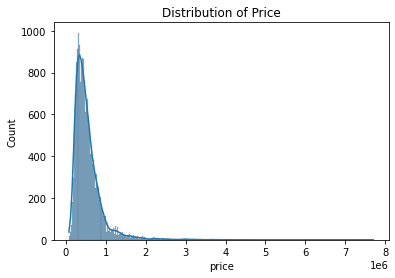

In [26]:
# Import the Seaborn and Matplotlib libraries for data visualization
sns.histplot(df['price'], kde=True)  # Create a histogram plot for the 'price' column
plt.title('Distribution of Price')  # Set the title for the plot
plt.show()  # Display the plot

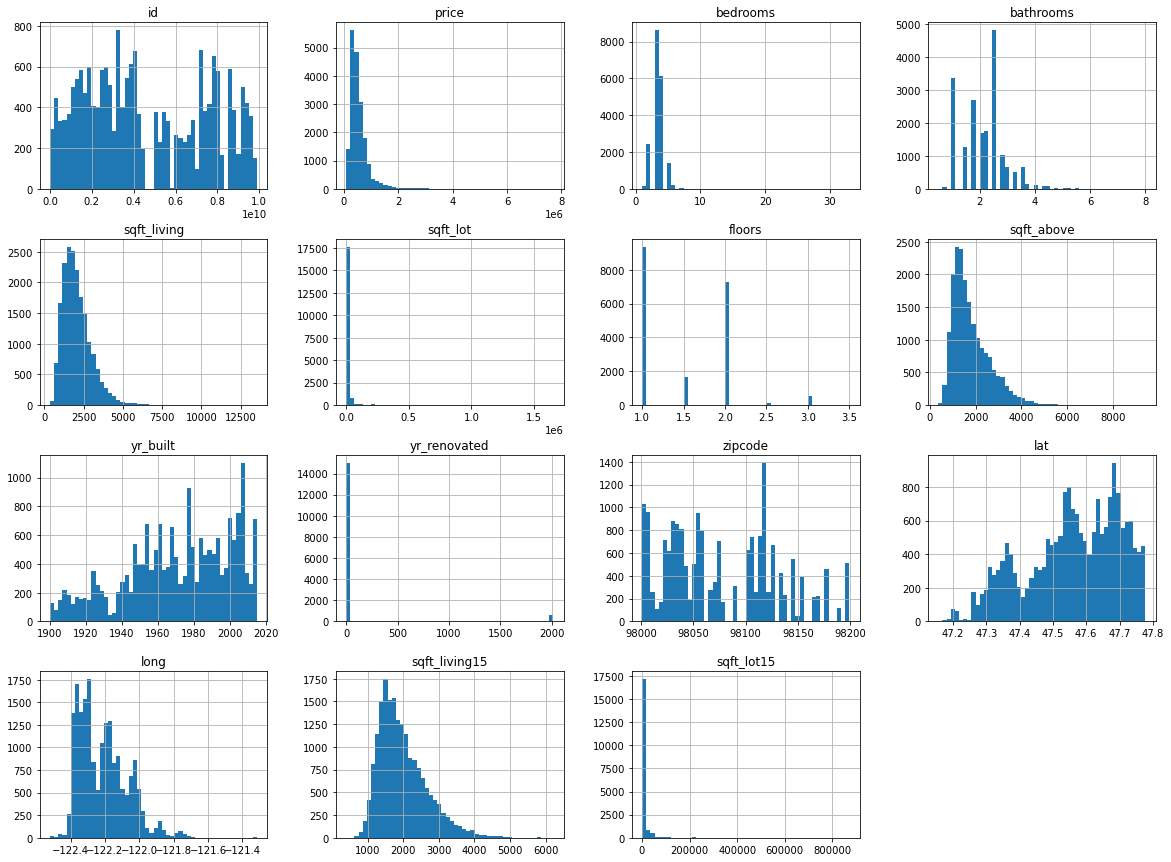

In [27]:
#set up a function to Create histograms for all columns in the DataFrame
def plot_histograms(data_frame, bins=50, figsize=(20, 15)):
    data_frame.hist(bins=bins, figsize=figsize)
    plt.show()


plot_histograms(df)


<AxesSubplot:xlabel='sqft_above', ylabel='price'>

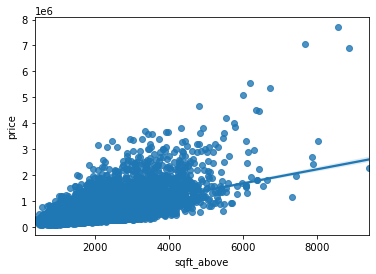

In [28]:
# Create a regression plot using Seaborn to explore the relationship between 'sqft_above' and 'price'
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x='sqft_above', y='price', data=df)

In [29]:
# Convert the 'sqft_basement' column to numeric, replacing non-numeric values with NaN.
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')

# Replace NaN values in the 'sqft_basement' column with 0.
df['sqft_basement'] = df['sqft_basement'].fillna(0)

# Convert the 'sqft_basement' values to integers, handling NaN values as None.
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: int(float(x)) if pd.notna(x) else None)

In [30]:
# Replace string values with numeric values in the DataFrame for the 'view' and 'waterfront' columns
# Mapping 'view' categories to numeric values
view_mapping = {'EXCELLENT': 4, 'GOOD': 3, 'AVERAGE': 2, 'FAIR': 1, 'NO': 0}
df.replace(view_mapping, inplace=True)

In [31]:
# Mapping 'waterfront' categories to numeric values
view_mapping = {'YES': 1, 'NO': 0}
df.replace(view_mapping, inplace=True)

In [32]:
# Mapping 'condition' categories to numeric values
view_mapping = {'Average': 3, 'Very Good': 5, 'Good': 4, 'Poor': 1, 'Fair': 2}
df.replace(view_mapping, inplace=True)

In [33]:
# Extract the numeric grade from the 'grade' column and store it in a new 'grade_int' column
df['grade_int'] = df['grade'].str.extract(r'(\d+)').astype(int)

# Drop the 'grade' column from the DataFrame
column_drop = 'grade'
df = df.drop(column_drop, axis=1)

In [34]:
# Preview the dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_int
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,7
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,NaN,98028,47.7379,-122.233,2720,8062,6
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000,7
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,8
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,3890,1530,2001,0.0,98053,47.6561,-122.005,4760,101930,11


In [35]:
# Confirm the unique values in the waterfront column. They should be '0' and '1'
df['waterfront'].unique()

array([0, 1], dtype=int64)

In [36]:
# Calculate and display the correlation matrix of the DataFrame 'df'
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_int
id,1.000000,-0.019219,0.002728,0.006519,-0.012911,-0.133958,0.017828,-0.004880,0.014068,-0.022813,-0.012369,-0.002847,0.022633,-0.010416,-0.007255,-0.006524,0.018949,-0.002234,-0.139255,0.006593
price,-0.019219,1.000000,0.309329,0.526036,0.703850,0.086395,0.256893,0.271527,0.395255,0.035922,0.608692,0.319018,0.050753,0.122900,-0.048031,0.305905,0.019495,0.580949,0.080894,0.666696
bedrooms,0.002728,0.309329,1.000000,0.516747,0.578524,0.029797,0.181755,-0.004183,0.083868,0.024352,0.480910,0.295752,0.156668,0.016556,-0.152507,-0.013258,0.131794,0.393864,0.028025,0.360649
bathrooms,0.006519,0.526036,0.516747,1.000000,0.755730,0.085276,0.505359,0.064609,0.185797,-0.129021,0.687386,0.277298,0.506215,0.047145,-0.200882,0.024612,0.222399,0.568908,0.086194,0.666311
sqft_living,-0.012911,0.703850,0.578524,0.755730,1.000000,0.172888,0.355893,0.107508,0.285337,-0.059540,0.877730,0.426675,0.315741,0.049859,-0.195441,0.052498,0.238614,0.755316,0.182870,0.763484
sqft_lot,-0.133958,0.086395,0.029797,0.085276,0.172888,1.000000,-0.008036,0.023128,0.071214,-0.014176,0.183716,0.014117,0.055218,0.002112,-0.130061,-0.085895,0.229976,0.145875,0.721689,0.114249
floors,0.017828,0.256893,0.181755,0.505359,0.355893,-0.008036,1.000000,0.021192,0.027781,-0.266144,0.523979,-0.239496,0.489822,-0.001385,-0.057422,0.050587,0.126026,0.279070,-0.011448,0.457470
waterfront,-0.004880,0.271527,-0.004183,0.064609,0.107508,0.023128,0.021192,1.000000,0.407505,0.017118,0.073470,0.086184,-0.026910,0.087869,0.031905,-0.013013,-0.040344,0.087340,0.031916,0.085743
view,0.014068,0.395255,0.083868,0.185797,0.285337,0.071214,0.027781,0.407505,1.000000,0.046807,0.168069,0.274744,-0.057609,0.098802,0.089685,0.009991,-0.078505,0.275601,0.071331,0.247601
condition,-0.022813,0.035922,0.024352,-0.129021,-0.059540,-0.014176,-0.266144,0.017118,0.046807,1.000000,-0.158258,0.167786,-0.364634,-0.061146,0.001751,-0.019051,-0.106342,-0.094257,-0.005553,-0.147841


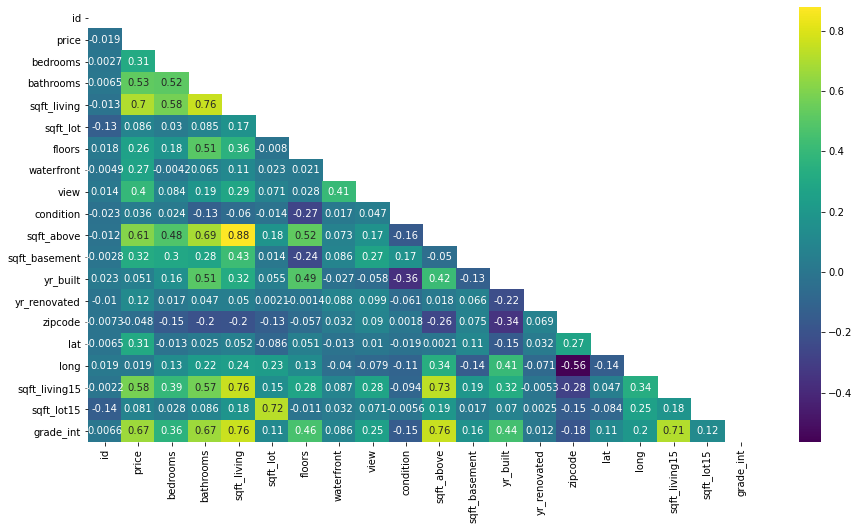

In [37]:
# Create a heatmap to visualize correlations
plt.figure(figsize=(15, 8))
mask = np.triu(df.corr())  # Create a mask to display only the upper half of the matrix
sns.heatmap(df.corr(), annot=True, cmap='viridis', mask=mask)
plt.show()


From above, the `sqft_living`, `grade_int` and `sqft_above` have the highest correlation with price.

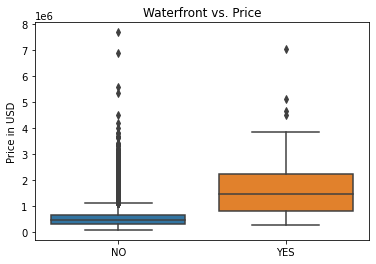

In [38]:
# Create a boxplot to compare 'waterfront' and 'price' with relevant labels and title
sns.boxplot(x=df['waterfront'], y=df['price'])
plt.title("Waterfront vs. Price")
plt.ylabel("Price in USD")
plt.xlabel(None)
plt.xticks(np.arange(2), ('NO', 'YES'))
plt.show()

Houses that have a `waterfront` are more expensive than houses without.

In [39]:
# Calculate the mean price for houses with and without waterfront, and print the results
waterfront_mean = df[df['waterfront'] == 1]['price'].mean()
nonwaterfront_mean = df[df['waterfront'] == 0]['price'].mean()
print(f"Mean price for houses with waterfront: {round(waterfront_mean, 2)}")
print(f"Mean price for houses with no waterfront: {round(nonwaterfront_mean, 2)}")

Mean price for houses with waterfront: 1692505.86
Mean price for houses with no waterfront: 533912.48


Calculating Mean House Prices for Properties with and without Waterfront

The provided code calculates and prints the mean prices for houses in a dataset, distinguishing between properties with a waterfront view ('waterfront' == 1) and those without a waterfront view ('waterfront' == 0).

**Output:**
- The mean price for houses with a waterfront view is approximately $1,692,505.86.
- The mean price for houses without a waterfront view is approximately $533,912.48.

These calculated mean prices provide valuable insights into the pricing differences between properties with and without waterfront views in the dataset. It indicates that, on average, houses with waterfront views tend to have a significantly higher price compared to those without such views.

Lets take a lok at some of the categorical features' relationship with `price`. 

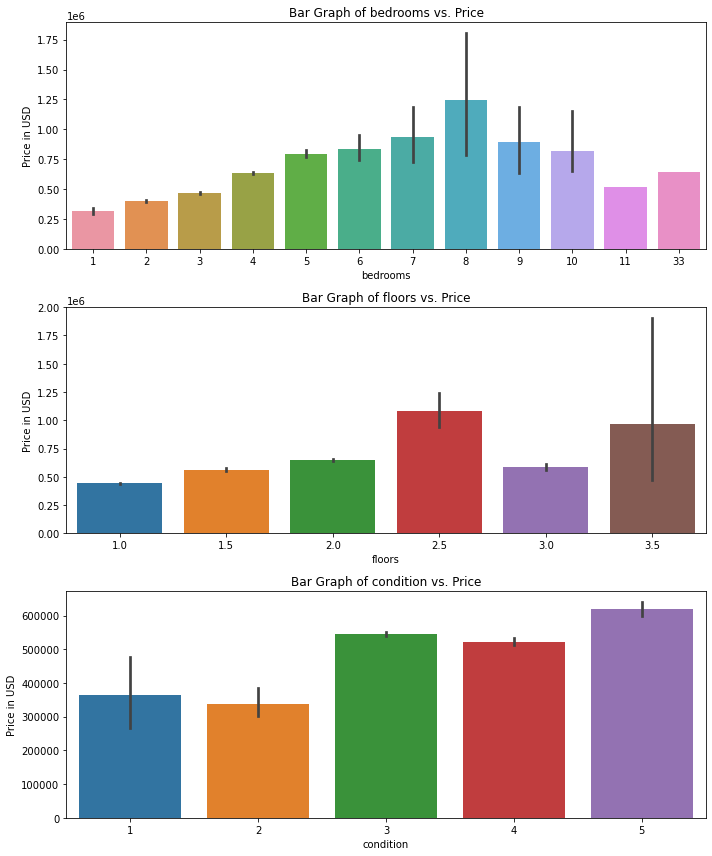

In [40]:
catfeats = ['bedrooms', 'floors', 'condition']

# Create subplots for bar graphs
fig, axes = plt.subplots(len(catfeats), figsize=(10, 12))

# Plot bar graphs for each categorical variable
for i, feature in enumerate(catfeats):
    sns.barplot(x=df[feature], y=df['price'], ax=axes[i])
    axes[i].set_title(f"Bar Graph of {feature} vs. Price")
    axes[i].set_ylabel("Price in USD")
    axes[i].set_xlabel(f"{feature}")

plt.tight_layout()
plt.show()

From the visualisations above:
- It can be noticed that as the number of `bedrooms` increase, so does the house's selling price.
- More `floors`, preferably up to 2.5 have a higher price  
- Houses prices also depend on the condition of the house

# How Location affects price

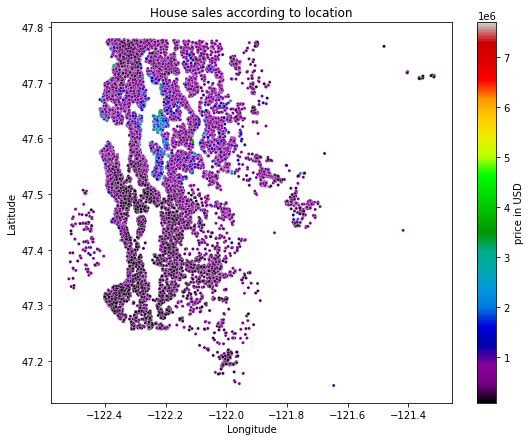

In [41]:
# Plot scatter plot
plt.figure(figsize = (9,7))
ax = sns.scatterplot(x = df['long'], y = df['lat'], hue = df['price'],
                palette = 'nipy_spectral',s=10, legend = None, data = df)

norm = plt.Normalize(df['price'].min(), df['price'].max())
smap = plt.cm.ScalarMappable(cmap='nipy_spectral', norm=norm)
smap.set_array([])

ax.figure.colorbar(smap, label = 'price in USD')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House sales according to location')
plt.show()
#run code to visualize

From the visualisation above, houses around latitude 47.6 to 47.7 and longitude -122.0 to -122.5 have some of the highest prices.

## Simple Linear Regression Model

In [42]:
# Import the necessary libraries for statistical modeling
import statsmodels
from statsmodels.formula.api import ols

# Define the dependent variable 'y' and the independent variable 'x'
y = df['price']
x = df['sqft_living']

# Create a linear regression model using Ordinary Least Squares (OLS)
model = ols(formula='price ~ sqft_living', data=df).fit()

In [43]:
# Display a summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 1.868e+04
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:38:05   Log-Likelihood:            -2.6454e+05
No. Observations:               19030   AIC:                         5.291e+05
Df Residuals:                   19028   BIC:                         5.291e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.743e+04   4721.791    -10.046      

### OLS Regression Results

Here we have the outcome of an Ordinary Least Squares (OLS) linear regression analysis that we used as our baseline model. It was performed on a dataset with 'price' as the dependent variable and 'sqft_living' as the independent variable. These results provide important information about the model's fit, coefficients, significance, and other statistical metrics.

Key Statistics:


- **R-squared (R²):**  R² is approximately 0.495, indicating that about 49.5% of the variation in 'price' can be explained by 'sqft_living.'

- **F-statistic:** A measure of the overall significance of the model. The high value (1.868e+04) suggests that the model is statistically significant.

- **Intercept (Intercept):** The estimated value of 'price' when 'sqft_living' is 0. The coefficient is approximately -47,430.

- **sqft_living (Coefficient for sqft_living):** The estimated change in 'price' for a one-unit increase in 'sqft_living.' In this case, it's approximately 283.1303.

These regression results provide valuable insights into the relationship between 'sqft_living' and 'price,' including the strength and significance of the relationship, potential issues, and diagnostic statistics for assessing the model's quality.


In [44]:
# Define a function to extract the month from the 'date' column and add it as a new 'month_of_sale' column
def month_of_sale_feature(data):
    data['month_of_sale'] = pd.DatetimeIndex(data['date']).month
    return data

In [45]:
# Apply the 'month_of_sale_feature' function to the DataFrame 'df' to create the 'month_of_sale' column
df = month_of_sale_feature(df)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_int,month_of_sale
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,7,12
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,NaN,98028,47.7379,-122.233,2720,8062,6,2
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0.0,98136,47.5208,-122.393,1360,5000,7,12
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0.0,98074,47.6168,-122.045,1800,7503,8,2
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,1530,2001,0.0,98053,47.6561,-122.005,4760,101930,11,5


In [46]:
# Define a function to categorize months into quarters
def quarter(month):
    if 1 <= month <= 3:
        quarter = 'Q1'
    elif 4 <= month <= 6:
        quarter = 'Q2'
    elif 7 <= month <= 9:
        quarter = 'Q3'
    else:
        quarter = 'Q4'
    return quarter

In [47]:
# Create a new 'quarter_of_sale' column by applying the 'quarter' function to the 'month_of_sale' column
df['quarter_of_sale'] = df['month_of_sale'].apply(quarter)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_int,month_of_sale,quarter_of_sale
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,7,12,Q4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,6,2,Q1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,7,12,Q4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,8,2,Q1
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,2001,0.0,98053,47.6561,-122.005,4760,101930,11,5,Q2


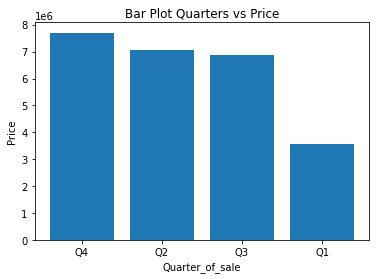

In [48]:
# Extract the categories (quarters) and values (prices) from the DataFrame
categories = df['quarter_of_sale']
values = df['price']

# Sort the data in descending order based on price values
sorted_data = sorted(zip(categories, values), key=lambda x: x[1], reverse=True)
quarters, prices = zip(*sorted_data)

# Create the bar graph with sorted data
plt.bar(quarters, prices)

# Add labels and title to the plot
plt.xlabel('Quarter_of_sale')  # Label for the x-axis
plt.ylabel('Price')  # Label for the y-axis
plt.title('Bar Plot Quarters vs Price')  # Title of the plot

# Display the final bar plot
plt.show()


The graph above shows that the most expensive houses are sold during the fourth quarter of the year

## Multiple Linear Regression Model

In [49]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_int,month_of_sale
id,1.000000,-0.019219,0.002728,0.006519,-0.012911,-0.133958,0.017828,-0.004880,0.014068,-0.022813,...,-0.002847,0.022633,-0.010416,-0.007255,-0.006524,0.018949,-0.002234,-0.139255,0.006593,-0.017817
price,-0.019219,1.000000,0.309329,0.526036,0.703850,0.086395,0.256893,0.271527,0.395255,0.035922,...,0.319018,0.050753,0.122900,-0.048031,0.305905,0.019495,0.580949,0.080894,0.666696,-0.008294
bedrooms,0.002728,0.309329,1.000000,0.516747,0.578524,0.029797,0.181755,-0.004183,0.083868,0.024352,...,0.295752,0.156668,0.016556,-0.152507,-0.013258,0.131794,0.393864,0.028025,0.360649,-0.001241
bathrooms,0.006519,0.526036,0.516747,1.000000,0.755730,0.085276,0.505359,0.064609,0.185797,-0.129021,...,0.277298,0.506215,0.047145,-0.200882,0.024612,0.222399,0.568908,0.086194,0.666311,0.009107
sqft_living,-0.012911,0.703850,0.578524,0.755730,1.000000,0.172888,0.355893,0.107508,0.285337,-0.059540,...,0.426675,0.315741,0.049859,-0.195441,0.052498,0.238614,0.755316,0.182870,0.763484,0.013389
sqft_lot,-0.133958,0.086395,0.029797,0.085276,0.172888,1.000000,-0.008036,0.023128,0.071214,-0.014176,...,0.014117,0.055218,0.002112,-0.130061,-0.085895,0.229976,0.145875,0.721689,0.114249,-0.005449
floors,0.017828,0.256893,0.181755,0.505359,0.355893,-0.008036,1.000000,0.021192,0.027781,-0.266144,...,-0.239496,0.489822,-0.001385,-0.057422,0.050587,0.126026,0.279070,-0.011448,0.457470,0.012816
waterfront,-0.004880,0.271527,-0.004183,0.064609,0.107508,0.023128,0.021192,1.000000,0.407505,0.017118,...,0.086184,-0.026910,0.087869,0.031905,-0.013013,-0.040344,0.087340,0.031916,0.085743,0.009211
view,0.014068,0.395255,0.083868,0.185797,0.285337,0.071214,0.027781,0.407505,1.000000,0.046807,...,0.274744,-0.057609,0.098802,0.089685,0.009991,-0.078505,0.275601,0.071331,0.247601,-0.005572
condition,-0.022813,0.035922,0.024352,-0.129021,-0.059540,-0.014176,-0.266144,0.017118,0.046807,1.000000,...,0.167786,-0.364634,-0.061146,0.001751,-0.019051,-0.106342,-0.094257,-0.005553,-0.147841,0.020945


In [50]:
# Create a multiple linear regression model using Ordinary Least Squares (OLS)
model = ols(formula='price ~  sqft_living + grade_int + bathrooms + waterfront + view + condition + yr_built + sqft_above + month_of_sale + lat + long', data=df).fit()
# + sqft_lot
# Display a summary of the regression model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3861.
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:            -2.5988e+05
No. Observations:               19030   AIC:                         5.198e+05
Df Residuals:                   19018   BIC:                         5.199e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.629e+07   1.61e+06    -22.508      0.000   -3.95e+07   -3.31e+07
sqft_living     132.9392      4.220     31.502      0.000     124.668     141.211
grade_int      1.077e+05   2227.994     48.328      0.000    1.03e+05    1.12e+05
bathrooms      3.421e+04   3330.035     10.272      0.000    2.77e+04    4.07e+04
waterfront     6.234e+05   1.89e+04     33.048      0.000    5.86e+05     6.6e+05
view           5.312e+04   2301.202     23.082      0.000    4.86e+04    5.76e+04
condition      2.736e+04   2512.419     10.890      0.000    2.24e+04    3.23e+04
yr_built      -2556.9171     72.768    -35.138      0.000   -2699.549   -2414.285
sqft_above       39.8137      4.238      9.395      0.000      31.508      48.120
month_of_sale -2785.3987    480.243     -5.800      0.000   -3726.718   -1844.079
lat            5.725e+05   1.13e+04     50.623      0.000     5.5e+05    5.95e+05
long          -1.089e+05   1.22e+04     -8.909      0.000   -1.33e+05   -8.49e+04
==============================================================================
Omnibus:                    16684.180   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1801406.023
Skew:                           3.732   Prob(JB):                         0.00
Kurtosis:                      50.076   Cond. No.                     3.81e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS Regression Results

The presented output displays the results of an Ordinary Least Squares (OLS) linear regression analysis. In this regression model, 'price' is considered the dependent variable, and several independent variables are included to predict the housing prices. Here's a breakdown of the key statistics and coefficients:

Key Statistics:

- **R-squared (R²):** R-squared value is approximately 0.691, indicating that approximately 69.1% of the variation in housing prices can be explained by the included independent variables.

- **F-statistic:** The F-statistic measures the overall significance of the model. The high F-statistic value (3861) suggests that the model is statistically significant.

  - 'sqft_living' has a coefficient of approximately 132.93, indicating that a one-unit increase in square footage of living space corresponds to an increase in price.
  - 'grade_int' and 'bathrooms' also have coefficients, suggesting their impact on the price.
  - Similar interpretations apply to other coefficients such as 'waterfront', 'view' and 'condition'.

These regression results provide insights into the relationships between various independent variables and housing prices, as well as the overall model fit and diagnostic statistics.


## Testing the models predicting performance

In [51]:
# Import necessary libraries and modules for data preprocessing, model creation, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# X = df.drop(['price', 'date', 'quarter_of_sale', 'sqft_basement'], axis=1)
X = df[['bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_above', 'yr_built', 'grade_int', 'month_of_sale', 'lat', 'long', 'condition']]
y = df['price']

# Split the data into training and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the number of test and training samples
print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

# Create a data preprocessing pipeline that includes data scaling and a linear regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the data
    ('regressor', LinearRegression())  # Linear Regression model
])

# Fit the pipeline on the training data, which includes scaling the features
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) as a measure of the model's prediction accuracy
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Number of test samples: 3806
Number of training samples: 15224
Root Mean Squared Error (RMSE): 200639.32145128777


In [52]:
# Create a separate Linear Regression model, fit it on the test data, and calculate the R-squared score
reg = LinearRegression()
reg.fit(X_test, y_test)
r2_score = reg.score(X_test, y_test)

# Print the R-squared score to evaluate the model's performance on the test data
print(f"R-squared Score: {r2_score}")


R-squared Score: 0.6920211643612745


### Evaluating the Model's Performance

In this code, a linear regression model has been trained, and its performance on the test data is assessed using two key metrics: Root Mean Squared Error (RMSE) and R-squared (R²) score.

#### Root Mean Squared Error (RMSE)

RMSE is a measure of the model's prediction accuracy. In this analysis, the RMSE is approximately 200,639.32. This value represents the square root of the average squared differences between the predicted housing prices and the actual prices in the test data. A lower RMSE indicates that the model's predictions are closer to the actual values, signifying better prediction accuracy.
Although our RMSE is large, in this context it is acceptable because the houses price ranges upto 7 million.

#### R-squared Score (R²)

R-squared (R²) measures the proportion of variance in the dependent variable ('price') that is explained by the independent variables used in the model. The R² score is approximately 0.692, which means that roughly 69.2% of the variation in housing prices can be explained by the features included in the model. A higher R² score indicates a better fit, suggesting that the model is successful in explaining a significant portion of the variance in housing prices.


## Building a New Model with Random Forest Regression

In [53]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  #

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r_squared:.2f}')


RMSE: 128296.20
R-squared (R²): 0.87


### The Random Forest Regression model yields the following results:

- Random Forest RMSE: 128,296.20
- Random Forest R-squared (R²): 0.87

### Optimizing Random Forest Regressor using Grid Search

In [54]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # You can adjust the number of estimators
    'max_depth': [None, 10],     # You can adjust the maximum depth
    'min_samples_split': [2, 5] # You can adjust the min samples split
}

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best estimator and best hyperparameters from the grid search
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Fit the best model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Calculate RMSE for the optimized model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Optimized RMSE: {rmse:.2f}')

# Calculate R-squared for the optimized model
r_squared = r2_score(y_test, y_pred)
print(f'Optimized R-squared (R²): {r_squared:.2f}')


### The optimized Random Forest Regression model yields the following results with a slightly lower RMSE:

- Optimized Random Forest RMSE: 127,472.58
- Optimized Random Forest R-squared (R²): 0.87

### Feature Importance

In [ ]:
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns  # Assuming you have feature names or column names

# Print and sort feature importances
sorted_feature_importances = sorted(zip(feature_importances, feature_names), reverse=True)
for importance, feature in sorted_feature_importances:
    print(f'{feature}: {importance:.4f}')


sqft_living: 0.3124
grade_int: 0.3087
lat: 0.1712
long: 0.0829
yr_built: 0.0291
waterfront: 0.0289
sqft_above: 0.0254
view: 0.0166
bathrooms: 0.0106
month_of_sale: 0.0097
condition: 0.0045


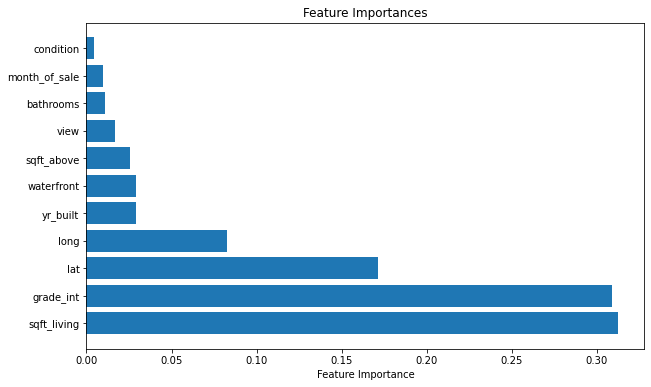

In [ ]:
# Extract feature importances and feature names
feature_importances = [importance for importance, _ in sorted_feature_importances]
feature_names = [feature for _, feature in sorted_feature_importances]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importances, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')

plt.show()

## Feature Importance Analysis

After analyzing the feature importance of the dataset, the following key features stand out:

- **sqft_living**: This feature has a high importance score of 0.3124, indicating that the living area square footage of a property plays a significant role in predicting house prices. A larger living area tends to positively influence the property's value.

- **grade_int**: Grade is another crucial factor, with an importance score of 0.3087. A higher grade is typically associated with a better quality of construction and design, leading to increased property values.

These results provide valuable insights into which features have the most influence on predicting house prices, with `sqft_living` and `grade_int` being the most significant factors.


## Conclusion

- **Baseline Model (OLS Regression Results):** The baseline model used 'sqft_living' to predict house prices. It explained approximately 49.5% of the price variation. The high F-statistic indicates the model's statistical significance.

- **Model with Multiple Variables (OLS Regression Results):** A more advanced model using multiple variables, including 'sqft_living,' 'grade_int,' and 'bathrooms,' explained about 69.1% of price variation. The model's high F-statistic suggests its statistical significance.

- **Random Forest Model:** A Random Forest model was developed, resulting in an RMSE of $128,296.20 and an R-squared of 0.87.

- **Optimized Random Forest Model:** After optimization, the Random Forest model achieved an RMSE of $127,472.58 and maintained an R-squared of 0.87.

- **Feature Importance:** The two most influential features for predicting house prices are 'sqft_living' with an importance score of 0.3124 and 'grade_int' with a score of 0.3087.

In conclusion, the analysis of various regression models and a Random Forest model for predicting house prices has provided valuable insights into the factors influencing housing prices. The findings can be valuable for real estate professionals, prospective buyers, and other stakeholders in the housing market to make informed decisions.
